# CNN Segmentation 
## Dog Example
### Ross Carmichael 1/10/21

In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing 

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Dataset oxford_iiit_pet downloaded and prepared to /Users/Ross/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [12]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

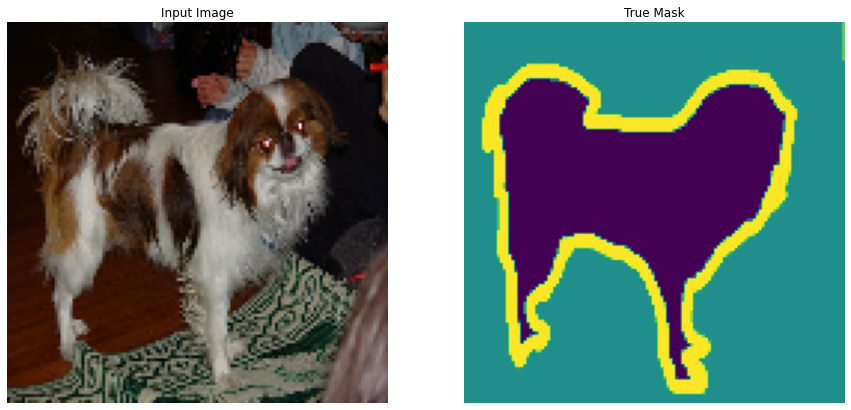

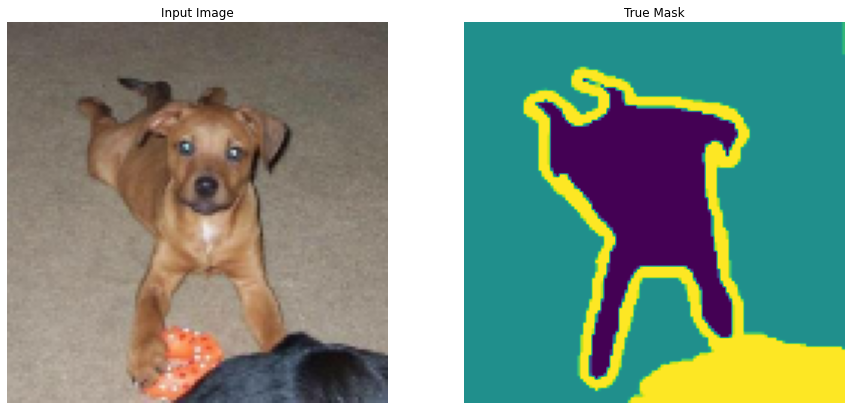

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


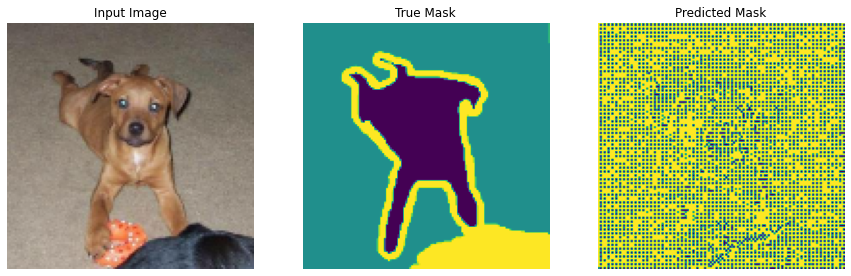

In [20]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

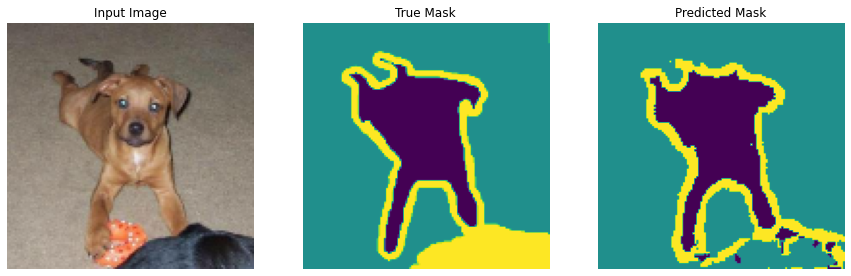


Sample Prediction after epoch 20


Epoch 00020: saving model to tf_segmentation/cp.ckpt


In [25]:
import os

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

checkpoint_path = "tf_segmentation/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), cp_callback])

In [28]:
!mkdir -p saved_model
model.save("saved_model/segmentation_model")

/Users/ross/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_model/segmentation_model/assets


INFO:tensorflow:Assets written to: saved_model/segmentation_model/assets


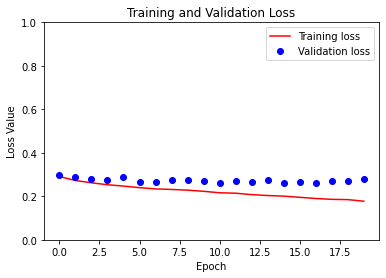

In [29]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

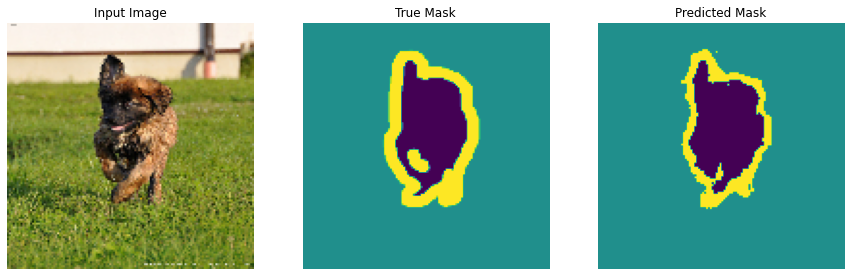

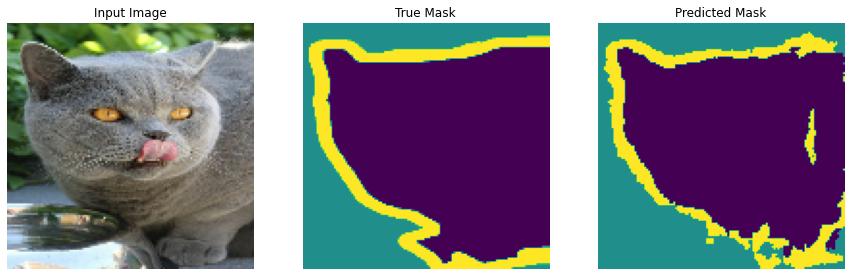

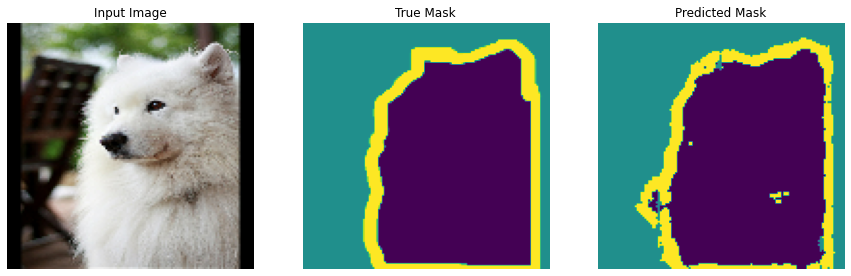

In [30]:
show_predictions(test_batches, 3)